## Introduction

In [Learning Transferable Visual Models From Natural Language Supervision paper](https://arxiv.org/abs/2103.00020), OpenAI introduces their new model which is called **CLIP**, for **Contrastive Language-Image Pre-training**. In a nutshell, this model learns the relationship between a whole sentence and the image it describes; in a sense that when the model is trained, given an input sentence it will be able to retrieve the most related images corresponding to that sentence. 

The important thing here is that it is trained on full sentences instead of single classes like car, dog, etc. The intuition is that when trained on whole sentences, the model can learn a lot more things and finds some pattern between images and texts.  CLIP model trained with this strategy classifies ImageNet better than those SOTA models trained on the ImageNet itself optimized for the only task of classification!

As a **teaser** (!), given a query (raw text) like "a boy jumping with skateboard" or "a girl jumping from swing", the model will retrieve the most relevant images:

![title_img](./figures/teaser.png)

In [1]:
#uncomment this if you are not using AIT proxy
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
import os
import cv2  #pip install opencv-python
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A

from matplotlib import pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/tmp/ipykernel_780209/1779922074.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

## 0. Config

In [4]:
class CFG:
    debug = False
    image_path = "data/images"  #download flickr-8k dataset
    captions_path = "data"      #this is the caption path
    batch_size = 32
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True  # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## 1. Load the dataset

First download the Flickr-8k dataset.  I downloaded from Kaggle and rename the `captions.txt` to `captions.csv`.  That's it and put it inside the folder `data`.

As you can see in the tittle image of this article, we need to encode both images and their describing texts. So, the dataset needs to **return both images and texts**. Here we will create our own custom `torch.utils.data.Dataset`.

`DistilBERT` model `HuggingFace` library is used as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the `input_ids` and the `attention_masks` to DistilBERT.

In the `__init__` we receive a tokenizer object which is actually a HuggingFace tokenizer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. 

In the `__getitem__` we will first load an encoded caption which is a dictionary with keys `input_ids` and` attention_mask`, make tensors out of its values and after that we will load the corresponding image, transform and augment it (to improve performance but we did not use any....) and then we make it a tensor and put it in the dictionary with `image` as the key. Finally we put the raw text of the caption with the key `caption` in the dictionary only for visualization purposes. 

In [5]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames #np array
        self.captions = list(captions)  #make numpy array to list
        self.encoded_captions = tokenizer(
            self.captions, padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        #item is simply input_ids and attention_masks that come from tokenizer

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        
        if image is None:
            print(f"image {self.image_filenames[idx]} does not exists!")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        #item['image'] = [channel, height, width] = torch.Size([3, 224, 224])        
        item['caption'] = self.captions[idx]
        
        #here, item refers to one pair of image and caption
        
        return item

    def __len__(self):
        return len(self.captions)

### Testing the CLIPDataset

First we will load the csv file and put it in the dataframe.  Then simply send this dataframe to the CLIPDatsaet.

In [6]:
def make_dfs():

    df = pd.read_csv(f"{CFG.captions_path}/captions.csv")

    #randomize ids for train and test
    max_id = df.index[-1] if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]

    #iloc accordingly
    train_df = df.iloc[train_ids].reset_index(drop=True)
    valid_df = df.iloc[valid_ids].reset_index(drop=True)
    
    return train_df, valid_df

In [7]:
train_df, valid_df = make_dfs()
train_df.shape, valid_df.shape

((32364, 2), (8090, 2))

In [8]:
train_df["image"].values[:5]

array(['1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg',
       '1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg',
       '1001773457_577c3a7d70.jpg'], dtype=object)

In [9]:
train_df["caption"].values[:5]

array(['A child in a pink dress is climbing up a set of stairs in an entry way .',
       'A little girl climbing into a wooden playhouse .',
       'A little girl climbing the stairs to her playhouse .',
       'A black dog and a spotted dog are fighting',
       'A black dog and a tri-colored dog playing with each other on the road .'],
      dtype=object)

Let's create the CLIPDataset by first defining the `tokenizer` and `transforms`.  The `tokenizer` is simply a bert tokenizer which adds [CLS] and [SEP].  The `transforms` is simply resize to same size image, and then perform some normalization.

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [11]:
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

transforms = get_transforms(mode="train")
transforms

Compose([
  Resize(always_apply=True, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=True, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Now let's create the `CLIPDataset`.

In [12]:
#construct the CLIP dataset object
dataset = CLIPDataset(
    train_df["image"].values,
    train_df["caption"].values,
    tokenizer=tokenizer,
    transforms=transforms,
)

Let's try to trigger `__getitem__` and see what happens.

In [13]:
dataset[0]

{'input_ids': tensor([ 101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275,
         1997, 5108, 1999, 2019, 4443, 2126, 1012,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'image': tensor([[[-0.8164, -0.3027,  0.0227,  ..., -2.0494, -2.0323, -2.0152],
          [-0.8678, -0.2342,  0.0741,  ..., -1.9638, -1.9980, -1.8782],
          [-0.9192, -0.1657,  0.0569,  ..., -1.9980, -2.0665, -2.0665],
          ...,
          [ 1.5297,  0.3309,  0.7762,  ...,  1.7009,  0.6906,  0.6906],
          [ 0.7248,  0.6049,  1.7523,  ...,  1.5982,  0.8276,  0.7591],
          [ 1.3927,  1.6495,  0.9474,  ...,  1.4612,  0.7933,  0.7762]],
 
         [[-0.6176,  0.1176,  0.4853,  ..., -2.0007, -1.9482, -1.8782],
          [-0.7052,  0.1702, 

## 2. Dataloaders

Here, we gonna create the dataloader, by putting the `CLIPDataset` into the pytorch `DataLoader`.

In [14]:
def build_loaders(df, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    
    #construct the CLIP dataset object
    dataset = CLIPDataset(
        df["image"].values,
        df["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

### Testing the dataloaders

In [15]:
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

In [16]:
for x in train_loader:
    print(f"{x['input_ids'].shape=}") #(bs, len)
    print(f"{len(x['caption'])=}") #(bs)
    break

for k, v in x.items():
    print(k)

x['input_ids'].shape=torch.Size([32, 39])
len(x['caption'])=32
input_ids
attention_mask
image
caption


## 3. Encoders

We need two encoders, image encoder and text encoder.  Then we shall do a dot product between the image and text representations to perform a contrastive learning.

### 3.1 Image Encoder

The image encoder code is straight forward. We are using PyTorch Image Models library (timm) here which makes a lot of different image models available from `ResNets` to `EfficientNets` and many more. Here we will use a `ResNet50` as our image encoder. You can easily use `torchvision` library to use `ResNets` if you don't want to install a new library.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of `ResNet50` the vector size will be **2048**). This is the output after the `nn.AdaptiveAvgPool2d()` layer.

In [17]:
class ImageEncoder(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Testing the image encoder

In [18]:
example = torch.randn((16, 3, 224, 224))  #(bs, ch, h, w)
encoder = ImageEncoder()
image_features = encoder(example)

image_features.shape  #the output is a one dimensional vector of size 2048 for each image.

torch.Size([16, 2048])

### 3.2 Text Encoder

We use DistilBERT as the text encoder (you can use any encoder actually....). Like its bigger brother BERT, two special tokens will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence. To grab the whole representation of a sentence, we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence (caption). Thinking it in this way, it is similar to what we did to images and converted them into a fixed size vector.

In the case of DistilBERT (and also BERT) the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [19]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]  #we are using the CLS token

### Testing the text encoder

In [20]:
textencoder = TextEncoder()
text_features = textencoder(x['input_ids'], x['attention_mask'])  #this is from when we test the dataloader up there....
text_features.shape #(bs, 768)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([32, 768])

### 3.3 Projection Head

Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text) we need to bring (project) them with **similar dimensions** (i.e., 256) for both images and texts in order to be able to compare them.

`embedding_dim` is the size of the input vector (2048 for images and 768 for texts) and `projection_dim` is the the size of the output vector which will be 256 for our case. To provide flexibility, we put some skip connections, layer norm as well as some gelu activation.

In [21]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected  #skip connection
        x = self.layer_norm(x) #normalize
        return x

Since this is too obvious, we shall skip the testing part....

## 4. Contrastive learning

In the `forward` function, we first encode the images and texts separately into fixed size vectors (with different dimensionalities). After that, using separate `projection` modules we project them to that shared world (space). Here the encodings will become of similar shape (256 in our case).

We have `image_embeddings`, a matrix with shape `(batch_size, 256)` and `text_embeddings` with shape `(batch_size, 256)`. To perform **contrastive learning**, we perform dot product (@ operator in PyTorch does the dot product or matrix multiplication in this case). To be able to multiply these two matrices together, we transpose the second one. 

We will get a matrix with shape `(batch_size, batch_size)`, i.e., `logits`. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes. Also look at the paper to see why it is here!).

Now that we have our logits, we need targets. So, in the best case scenario, `text_embeddings` and `image_embedding` matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [22]:
# A simple Example
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T

print(out)  #notice how the diagonal has the biggest value....

print(F.softmax(out, dim=-1))  #if we softmax, we get mostly 1 in the diagonal...

tensor([[231.1975,  -0.2570, -11.7631, -21.2653],
        [ -0.2570, 255.6252,  -3.7450, -18.0371],
        [-11.7631,  -3.7450, 249.0547, -19.1521],
        [-21.2653, -18.0371, -19.1521, 244.9865]])
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


So `logits`, in the best case, will be a matrix that if we take its softmax, will have 1.0s in the diagonal (An identity matrix!). As the loss function's job is to make model's predictions similar to targets (at least in most cases!), we want such a matrix as our target.

Now that we've got our `targets` matrix, we will use simple `cross entropy` to calculate the actual loss.

Actually there's a simpler way to calculate this loss in PyTorch; by doing this: `nn.CrossEntropyLoss()(logits, torch.arange(batch_size))`. However, the dataset we are using has multiple captions for a single image; so, there is the possibility that two identical images with their similar captions exist in a batch (it is rare but it can happen). Taking the loss with this easier method will ignore this possibility and the model learns to pull apart two representations (assume them different) that are actually the same.

In [23]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"]) #(bs, 2048)
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        ) #(bs, 768)
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features) #(bs, 256)
        text_embeddings = self.text_projection(text_features) #(bs, 256)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature  #(bs, bs)
        images_similarity = image_embeddings @ image_embeddings.T  #diagonal will be big number (note not yet softmax)
        texts_similarity = text_embeddings @ text_embeddings.T  #diagonal will be big number
        
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1  #looks like an identity matrix
        )
                
        texts_loss  = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)  #simply cross entropy.... sum (-y log yhat)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

### Testing the model

In [24]:
model = CLIPModel()#.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
#x is from above....
loss = model(x)

In [26]:
loss

tensor(14.3580, grad_fn=<MeanBackward0>)

### 5. Training

This is simply an avg meter for calculating loss.  You can skip this if you are lazy.

In [27]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):  #add current loss, the average
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the `optimizer` and `lr_scheduler`.

In [28]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [29]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!


## 6. Inference

Okay! We are done with training the model. Now, we need to do inference which in our case will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the `image_embeddings` with shape `(valid_set_size, 256)` and the model itself.

In [30]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [31]:
_, valid_df = make_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/253 [00:00<?, ?it/s]

### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, `image_embeddings`, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [32]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n  = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

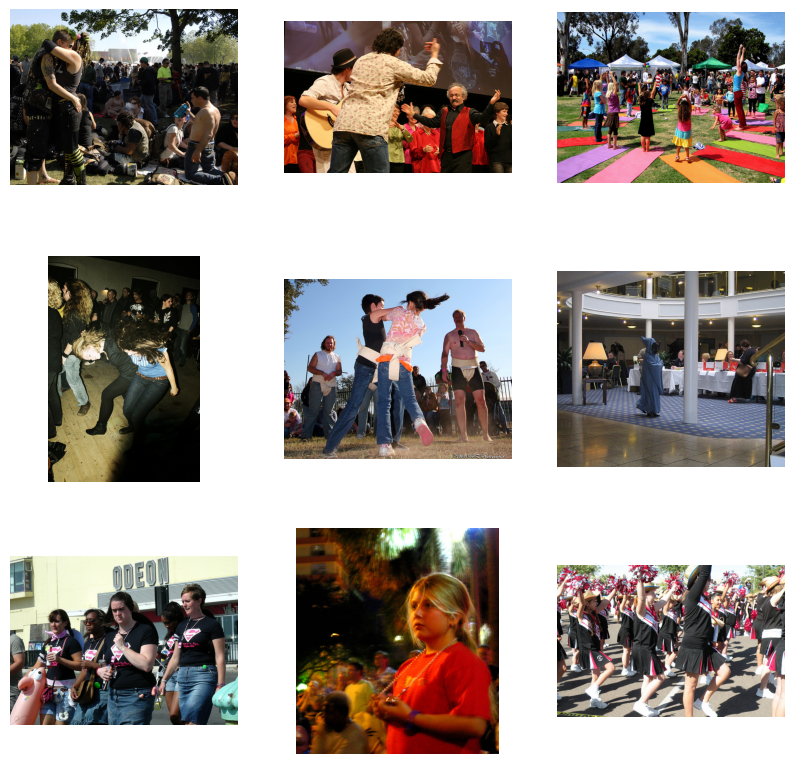

In [33]:
find_matches(model, 
             image_embeddings,
             query="a group of people dancing in a party",
             image_filenames=valid_df['image'].values,
             n=9)